In [25]:
from graph_diversity_problems.utils import save_graphs_in_adj_matrices, Graph
import sys


sys.path.append("../../graph_diversity_problems/")

from graph_diversity_problems.analysis import draw_graphs, _metrics_for_graph, create_df_from_run

import networkx as nx
import numpy as np
from pathlib import Path

from typing import List


from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from typing import Dict, List, Tuple

from tqdm.notebook import tqdm
from functools import partial

In [153]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  white solid !important;
  color: white !important;
}
</style>

In [154]:
# N = 64

# save_dir : Path = Path("../test_data/") 

In [155]:
# def create_er_random_graphs(amount: int=100,
#                            size: int=N,
#                            ) -> List[Graph]:
    
#     P = sorted(np.random.uniform(low=0, high=1, size=amount))    
    
#     return [nx.random_graphs.fast_gnp_random_graph(
#         n=size,
#         p=p,
#     ) for p in P]

In [156]:
# er_graphs = create_er_random_graphs()

In [157]:
# Check uniform distribution of p
# y = sorted(np.random.uniform(low=0, high=1, size=100))
# x = range(len(y))

# px.scatter(x=x, y=y)

In [189]:
baseline_cols_names =[("Baseline", "ed"), ("Baseline", "none")]
algorithms = ["articulation_points", "bfs", "bridges"]

baseline_cols = pd.MultiIndex.from_tuples(baseline_cols_names, names=["test", "hintmode"])
data = [['88.93\u00B11.92', '81.97\u00B15.08'], 
        ['99.64\u00B10.03', '99.89\u00B10.03'],
        ['93.75\u00B12.73', '95.62\u00B11.03'],
        ]

BASELINE_DF = pd.DataFrame(data=data, columns=baseline_cols, index=algorithms)
BASELINE_DF_SIMPLE = pd.DataFrame(data=data, columns=["ed", "none"], index=algorithms)
BASELINE_DF_SIMPLE

,ed,none
articulation_points,88.93±1.92,81.97±5.08
bfs,99.64±0.03,99.89±0.03
bridges,93.75±2.73,95.62±1.03


In [159]:
def get_directories_from_a_template(*template_strs_seeds: str):
    
    dir_to_dataset_list = []
    
    for template_str in template_strs_seeds:
        datadirs = [Path(f"../data/{template_str}/test_from_dataset_encoded_decoded_hints/"),
                    Path(f"../data/{template_str}/test_from_dataset_no_hints/"),
                    Path(f"../data/{template_str}/test_from_failed_generator_encoded_decoded_hints/"),
                    Path(f"../data/{template_str}/test_from_failed_generator_no_hints/"),
                ]
        labels = [("dataset", "ed"), ("generator", "ed"), ("dataset", "none"), ("generator", "none")]
        
        dir_to_dataset = dict(
            filter(
                lambda x: x[1].exists(),
                zip(labels, datadirs)
            )
        )
        
        dir_to_dataset_list.append(dir_to_dataset)
    
    return dir_to_dataset_list

In [160]:
def obtain_info_about_test_from_datasets(*datadirs_dicts: Dict[Tuple[str, str], Path]) -> pd.DataFrame:
    
    
    final_dfs = []
    for datadir_to_labels in datadirs_dicts:
        dataframes: List[pd.DataFrame] = []
        
        test_sources: List[str] = []
        hint_modes: List[str] = []
        full_labels: List[str] = []
        # print(datadir_to_labels)
        for (test_source, hint_mode), datapath in datadir_to_labels.items():
            
            dataframe = pd.read_csv(datapath / "dumps_df.csv").query("type == 'test'")[["algorithm", "score", "seed"]]
            
            dataframes.append(dataframe)
            
            size = dataframe.shape[0]
            
            test_sources.extend([test_source] * size)
            hint_modes.extend([hint_mode] * size)
            full_labels.extend([test_source + hint_mode] * size)
            
        
        final_df = pd.concat(dataframes).reset_index(drop=True)
        final_df["test_source"] = test_sources
        final_df["hint_mode"] = hint_modes
        final_df["full_label"] = full_labels
        final_df["SCORE"] = final_df["score"] * 100

        
        final_dfs.append(final_df)
    
    return final_dfs
    

In [161]:
def df_style(val):
    return "font-weight: bold"


In [173]:
def create_summary(dataframe, value:str, round_int:int=4):
    

    a = dataframe.pivot_table(
        values=[value],
        columns=["test_source", "hint_mode"],
        index=["algorithm"],
        aggfunc=["mean", "std", "sem"]
    )
    
    data_for_new_table = []

    for _, row in a.iterrows():
        
        means_pm_stds = []
        for test_source, hintmode in (("dataset", "ed"),
                                    ("dataset", "none"),
                                    ("generator", "ed"),
                                    ("generator", "none")):
            
            mean = round(row["mean", value, test_source, hintmode], round_int)
            standard_error = round(row["sem", value, test_source, hintmode], round_int)
            
            means_pm_stds.append(f'{mean:.2f}\u00B1{standard_error:.2f}')
        data_for_new_table.append(means_pm_stds)
        
    new_columns =[
    (dataset, hintmode) for dataset, hintmode in (("dataset", "ed"),
                                                ("dataset", "none"),
                                                ("generator", "ed"),
                                                ("generator", "none"))
    ]

    columns_indices = pd.MultiIndex.from_tuples(new_columns, names=["test", "hintmode"])
    b = pd.DataFrame(data=data_for_new_table, index=a.index, columns=columns_indices)
    
    # summary = pd.concat([b, BASELINE_DF], axis=1)
    summary = b
    
    # summary.style.applymap(df_style, subset=baseline_cols)
    
    return summary

In [225]:
def create_separate_ed_nohints_reports(*summary_dfs: pd.DataFrame, value:str="SCORE", round:int=2):
    
    
    
    seed_sets = [f"#{i}" for i in range(1, len(summary_dfs)+1)]
    
    seeds_summaries: Dict[str, pd.DataFrame] = dict(
        zip(
            seed_sets,
            map(partial(create_summary, value=value, round_int=round),
                summary_dfs)
        )
    )
    
    hintmodes = ["ed", "none"]
    hintmodes_summaries: List[pd.DataFrame] = []
    
    ROWS = BASELINE_DF_SIMPLE.index.values
    
    for hintmode in hintmodes:
        
        data = []
        
        for seedset, summary_for_seed in seeds_summaries.items():
            
            seedset_summary_for_hint = summary_for_seed.loc[:, 
                                                            summary_for_seed.columns.get_level_values(1) == hintmode
                                                            ]
            
            seedset_summary_for_hint.columns = seedset_summary_for_hint.columns.droplevel(1) # drop level of multicolumn
            
            for col in seedset_summary_for_hint.columns:
                
                try:
                    seedset_col_data_flattened = seedset_summary_for_hint.loc[ROWS, col].values
                except KeyError:
                    seedset_col_data = {}
                    for row in set(ROWS) & set(seedset_summary_for_hint.index.values):
                        seedset_col_data[row] = seedset_summary_for_hint.loc[row, col]
                    
                    seedset_col_data_flattened = [seedset_col_data.get(rowname) for rowname in ROWS]
                finally:
                    columnane_seedset = (col.capitalize(), seedset)
                    data.append((columnane_seedset, seedset_col_data_flattened))
                    
                    
        data.sort(key=lambda x: x[0])
        
        data = {key: val for key, val in data}
        data[("Baseline", "")] = BASELINE_DF_SIMPLE[hintmode].values
    
        hintmode_df = pd.DataFrame(data=data, index=ROWS).dropna()
        # hintmode_df.columns.set_name(["123123", "aa"])
        # hintmode_df.index = ROWS
        
        hintmodes_summaries.append(hintmode_df)
    
    return dict(zip(
        hintmodes,
        hintmodes_summaries
    ))

In [226]:
def create_summary_for_each_hintmode_from_templates(*templates: str):
    dirs_from_templates = get_directories_from_a_template(*templates)
    test_results_list_for_each_run = obtain_info_about_test_from_datasets(*dirs_from_templates)
    summaries_dict = create_separate_ed_nohints_reports(*test_results_list_for_each_run)
    
    return summaries_dict

In [227]:
TEMPLATES = ["test_article", "test_article_different_seeds"]
# TEMPLATES = ["test_article_art_points"]
summaries_dict = create_summary_for_each_hintmode_from_templates(*TEMPLATES)

In [230]:
summaries_dict["ed"]

Dataset                Generator              \
                             #1          #2           #1          #2   
articulation_points  87.91±3.61  86.11±6.37  61.22±14.42  80.29±5.56   
bfs                  99.63±0.10  99.65±0.08   99.89±0.03  99.95±0.02   
bridges              93.72±3.09  92.41±3.99   94.50±0.90  93.27±0.56   

                       Baseline  
                                 
articulation_points  88.93±1.92  
bfs                  99.64±0.03  
bridges              93.75±2.73

In [228]:
summaries_dict["ed"].to_csv("ed_table.csv")

In [231]:
summaries_dict["none"]

Dataset                Generator               \
                             #1          #2           #1           #2   
articulation_points  92.29±0.91  93.08±1.55  59.28±11.06  71.95±10.30   
bfs                  99.79±0.08  99.70±0.09   99.85±0.07   99.84±0.05   
bridges              86.07±7.37  90.70±3.17   94.76±1.06   92.42±3.42   

                       Baseline  
                                 
articulation_points  81.97±5.08  
bfs                  99.89±0.03  
bridges              95.62±1.03

In [229]:
summaries_dict["none"].to_csv("nohints_table.csv")

In [12]:
G = nx.random_graphs.fast_gnp_random_graph(n=16, p=0.5, directed=False)
nx.minimum_spanning_tree(G)

In [13]:
def draw_graph_from_matrix(G):
    nx.draw_networkx(nx.from_numpy_array(G), with_labels=True)

In [14]:
G = np.random.binomial(n=1, p=0.5, size=(3,3))
G

array([[1, 0, 1],
       [0, 0, 1],
       [0, 1, 1]])

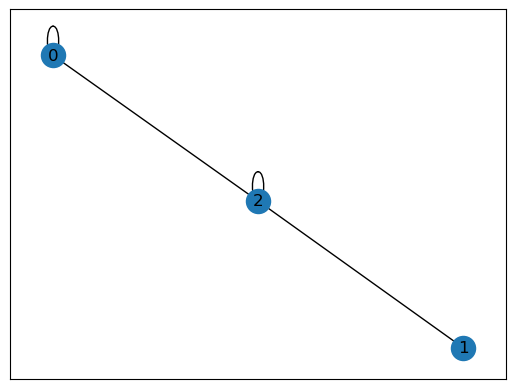

In [15]:
draw_graph_from_matrix(G)

In [16]:
mat = np.triu(G, k=1)
mat

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 0]])

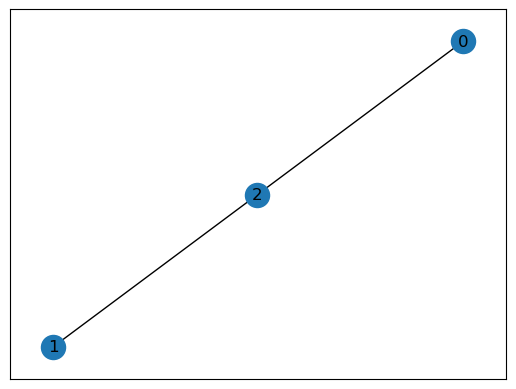

In [17]:
draw_graph_from_matrix(mat)

In [18]:
p = np.random.permutation(3)
# p = np.arange(3)

p

array([2, 0, 1])

In [19]:
mat

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 0]])

In [20]:
mat[p, :]

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [21]:
# mat[:, p]

In [22]:
mat[p, :][:, p]

array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [23]:
mat = mat[p, :][:, p]
mat

array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [24]:
G

array([[1, 0, 1],
       [0, 0, 1],
       [0, 1, 1]])

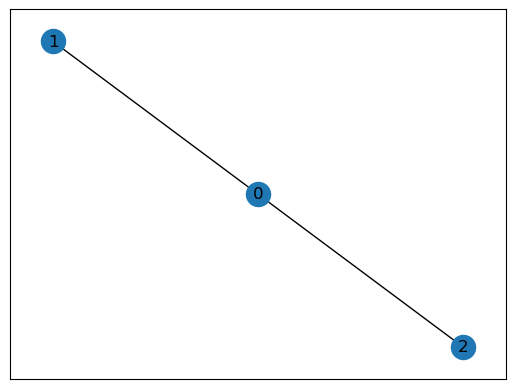

In [25]:
draw_graph_from_matrix(mat)

In [26]:
G[np.tril_indices_from(G, k=-1)] = -1
G


array([[ 1,  0,  1],
       [-1,  0,  1],
       [-1, -1,  1]])

In [27]:

G += np.transpose(G)

In [28]:
G

array([[ 2, -1,  0],
       [-1,  0,  0],
       [ 0,  0,  2]])

In [29]:
A = np.arange(5)
np.random.shuffle(A)
A

array([3, 0, 1, 2, 4])

In [30]:
def get_undirected_from_directed(G):
    
    m = nx.to_numpy_array(G)
    m[np.tril_indices_from(m)] = 0
    m += np.transpose(m)
    
    return nx.from_numpy_array(m)
    

In [31]:
d_1 = np.mean([nx.density(nx.random_graphs.gnp_random_graph(100, 0.5, directed=True)) for _ in range(100)])
d_2 = np.mean([nx.density(nx.random_graphs.gnp_random_graph(100, 0.5, directed=False)) for _ in range(100)])
d_3 = np.mean([nx.density(get_undirected_from_directed(nx.random_graphs.gnp_random_graph(100, 0.5, directed=True))) for _ in range(100)])


In [32]:
print(d_1, d_2, d_3)

0.49983232323232324 0.49977777777777777 0.49982424242424245


In [56]:
def return_graphs_from_npy(filepath):
    with open(filepath, "rb") as h:
    
        graphs = np.load(h)
        np.random.shuffle(graphs)
    return [nx.from_numpy_array(g) for g in graphs]

In [57]:
def read_directories_and_get_graphs_in_dict(directories_and_labels: List[Tuple[str, str]], number_of_graphs:int=None):
    D = {}
    
    for directory, label in directories_and_labels:
        
        graphs = return_graphs_from_npy(directory)
        if number_of_graphs:
            graphs = graphs[:number_of_graphs]
        
        D[label] = [(graphs, label)]
    return D

In [58]:
data_directories = [
    ("../data/test_article_test_graphs_from_df/bfs/seed_1/graphs_from_test.npy", "dataset-bfs"),
    ("../data/test_article_test_graphs_from_df/bridges/seed_1/graphs_from_test.npy", "dataset-bridges"),
    ("../data/test_article_test_graphs_from_df/articulation_points/seed_1/graphs_from_test.npy", "dataset-art.points"),

]

In [65]:
# N = 3232
# D = read_directories_and_get_graphs_in_dict(data_directories, number_of_graphs=None)

In [66]:

# graphs_dict = {
#     # "dataframe-bfs": [
#     #     (graphs, "bfs")
#     # ],
#     # "dataframe-bridges": [
#     #     (graphs_1, "bridges")  
#     # ],
#     # "dataframe-art. points":
#     #     [
#     #       (graphs_2, "points")  
#     #     ],
    
#     "ER-0.5": [
#         ([nx.random_graphs.gnp_random_graph(n=64, p=0.5) for _ in range(N)], "er-0.5")
#     ],
#     "ER-0.25": [
#         ([nx.random_graphs.gnp_random_graph(n=64, p=0.25) for _ in range(N)], "er-0.25")
#     ],
#     "ER-0.04": [
#         ([nx.random_graphs.gnp_random_graph(n=64, p=0.04) for _ in range(N)], "er-0.25")
#     ],
#     "ER-0.2": [
#         ([nx.random_graphs.gnp_random_graph(n=64, p=0.2) for _ in range(N)], "er-0.2")
#     ],
# }
# graphs_dict.update(D)

In [83]:
# df = create_df_from_run(graphs_and_its_label=graphs_dict, isomorphic=False, shortest_paths=False)
df = pd.read_csv("graphs_from_dataset_properties.csv", index_col=0)

In [84]:
df

,radius,diameter,density,efficiency,transitivity,total_triangles,avg_clustering_coefficient,number_of_connected_components,avg_node_degree,skewness,kurtosis,avg_shortest_path_lentgh,label,iso,model,isomorphic_graphs
0,2,2,0.500000,0.750000,0.499038,15564,0.499770,1,31.50000,-0.134231,0.630874,1.500000,er-0.5,NaN,ER-0.5,NaN
1,2,2,0.524802,0.762401,0.520912,17898,0.520394,1,33.06250,-0.291115,-0.528616,1.475198,er-0.5,NaN,ER-0.5,NaN
2,2,2,0.495040,0.747520,0.499821,15333,0.499779,1,31.18750,0.170871,-0.539498,1.504960,er-0.5,NaN,ER-0.5,NaN
3,2,2,0.504464,0.752232,0.504822,16122,0.506872,1,31.78125,0.287593,-0.682091,1.495536,er-0.5,NaN,ER-0.5,NaN
4,2,2,0.486607,0.743304,0.487387,14394,0.486586,1,30.65625,-0.455496,-0.289832,1.513393,er-0.5,NaN,ER-0.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22619,0,12,0.034226,0.153610,0.000000,0,0.000000,14,2.37500,0.095112,-0.873254,2.561012,dataset-art.points,NaN,dataset-art.points,NaN
22620,0,9,0.040923,0.225508,0.080214,15,0.050670,9,2.75000,0.548513,0.051160,3.009425,dataset-art.points,NaN,dataset-art.points,NaN
22621,0,8,0.048363,0.280498,0.044944,12,0.029167,6,3.15625,0.240639,-0.407424,3.122520,dataset-art.points,NaN,dataset-art.points,NaN
22622,0,7,0.054067,0.320698,0.044910,15,0.035640,3,3.56250,0.429120,-0.579605,3.031250,dataset-art.points,NaN,dataset-art.points,NaN


In [78]:
properties = ['diameter', 
              'density', 
              'efficiency', 
            #   'transitivity',
              'total_triangles', 
              'avg_node_degree', 
            #   'skewness',
            #   'kurtosis',
            # "avg_shortest_path_lentgh"
              ]

In [79]:
from plotly.colors import DEFAULT_PLOTLY_COLORS

In [75]:
df.to_csv("graphs_from_dataset_properties.csv")

In [154]:
fig = make_subplots(
    rows=len(properties),
    subplot_titles=list(map(lambda x: x.upper(), properties)),
)

showlegend=True
for row, prop in enumerate(properties, 1):

    fig.add_trace(go.Box(x=df.query("model == 'dataset-bfs'")[prop], 
                         name="Dataset-bfs", 
                         legendgroup="group1", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[0])), 
                  row=row, col=1)
    fig.add_trace(go.Box(x=df.query("model == 'dataset-bridges'")[prop], 
                         name="Dataset-bridges", 
                         legendgroup="group2", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[1])), 
                  row=row, col=1)
    
    fig.add_trace(go.Box(x=df.query("model == 'dataset-art.points'")[prop], 
                         name="Dataset-art.points", 
                         legendgroup="group3", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[2])), 
                  row=row, col=1)
    
#     fig.add_trace(go.Box(x=df.query("model == 'ER-0.5'")[prop], 
#                          name="ER-0.5", 
#                          legendgroup="group4", 
#                          showlegend=showlegend,
#                          line=dict(color=DEFAULT_PLOTLY_COLORS[3])), 
#                   row=row,col=1)
    
    fig.add_trace(go.Box(x=df.query("model == 'ER-0.25'")[prop], 
                         name="ER-0.25", 
                         legendgroup="group5", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[4])), 
                  row=row, col=1)
    
    fig.add_trace(go.Box(x=df.query("model == 'ER-0.04'")[prop], 
                         name="ER-0.04", 
                         legendgroup="group6", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[5])), 
                  row=row, col=1)
    fig.add_trace(go.Box(x=df.query("model == 'ER-0.2'")[prop], 
                         name="ER-0.2", 
                         legendgroup="group7", 
                         showlegend=showlegend,
                         line=dict(color=DEFAULT_PLOTLY_COLORS[6])), 
                  row=row, col=1)

    showlegend = False

fig.update_layout(height=1500, width=800,
                  title_text="Basic graph properties of CLRS standard dataset and ER models")
fig.show()